<a href="https://colab.research.google.com/github/TakahisaShiratori/bayesianopt-openfoam-rescale/blob/master/damBreak_with_rescale_persistent_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running Optimization Workflow of CFD with OpenFOAM, GPyOpt and Rescale

## Overview
This Notebook is an example to run CFD optimization workflow with [Rescale](https://www.rescale.com/). As optimization algorism, Bayesian optimization in GPyOpt is used, and it runs on the Notebook. [OpenFOAM 6](https://openfoam.org/version/6/) is used as a CFD software, and it runs on Rescale. The Notebook submits jobs to Rescale with [REST API](https://docs.rescale.com/articles/rest-api/). 
[OpenFOAMandBaysianOpt_Notebooks](https://github.com/TatsuyaKatayama/OpenFOAMandBaysianOpt_Notebooks), which is used as a material in [Open CAE Symposium 2019 Training](http://www.opencae.or.jp/activity/symposium/opencae_symposium2019/training/), provided inspiration to this Notebook.

## Disclaimers

By runnning the workflow in this Notebook, Rescale charges usage fee for clusters, storage and data transfer.

I (@TakahisaShiratori) am not responsible for any bugs in this Notebook. Please run on your own responsibility.

In [0]:
rescale_api_key = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"

# Allowed values for platform are "platform.rescale.com", "platform.rescale.jp" and "kr.rescale.com"
platform = "platform.rescale.jp"

In [0]:
token_in_header = "Token " + rescale_api_key

if platform == "platform.rescale.com":
  template_jobid = "XPEsQc"
  print("Template Job ID: " + template_jobid)
elif platform == "platform.rescale.jp":
  template_jobid = "GHVjd"
  print("Template Job ID: " + template_jobid)
elif platform == "kr.rescale.com":
  template_jobid = "TRJOc"
  print("Template Job ID: " + template_jobid)
else:
  print("Allowed values for platform are platform.rescale.com, platform.rescale.jp and kr.rescale.com")

Template Job ID: GHVjd


In [0]:
cluster_configuration = {
  "name": "OpenFOAM 6 Persistent Cluster",
  "hardware": {
    "coresPerSlot": 1,
    "slots": 1,
    "coreType": "emerald",
    "walltime": 5
  },
  "installedAnalyses": [
    {
      "analysis": {
        "code": "openfoam",
        "version": "6-intelmpi"
      }
    }
  ],
  "runLowPriority": True
}

In [0]:
import json
import requests
import time

# Create Cluster
raw_reply = requests.post(
  "https://" + platform + "/api/v2/clusters/", 
  headers={"Authorization": token_in_header}, 
  json=cluster_configuration
)
created_cluster = json.loads(raw_reply.text)
print("Cluster ID: " + created_cluster["id"])

# Start Cluster
requests.post(
  "https://" + platform + "/api/v2/clusters/" + created_cluster["id"] + "/start/",
  headers={"Authorization": token_in_header}
)

time.sleep(10)

# Get the Cluster's Status
raw_reply = requests.get(
  "https://" + platform + "/api/v2/clusters/" + created_cluster["id"] + "/statuses/",
  headers={"Authorization": token_in_header}
)
cluster_statuses = json.loads(raw_reply.text)
print("Cluster ID: " + created_cluster["id"] + ", Status date: " + cluster_statuses["results"][0]["statusDate"] + ", Status: " + cluster_statuses["results"][0]["status"])

Cluster ID: BBVthb
Cluster ID: BBVthb, Status date: 2020-03-17T09:36:56.232534Z, Status: Queued


In [0]:
def get_a_specific_job(jobid):
  raw_reply = requests.get(
    "https://" + platform + "/api/v2/jobs/" + jobid + "/", 
    headers={"Authorization": token_in_header},
  )
  job_configuration = json.loads(raw_reply.text)
  return job_configuration

template_job_configuration = get_a_specific_job(template_jobid)
print(template_job_configuration)

{'id': 'GHVjd', 'isLowPriority': True, 'name': 'OpenFOAM 6 damBreak (Template Job)', 'owner': 'takahisa@rescale.com', 'resourceFilters': [], 'archiveFilters': [], 'cidrRule': '', 'publicKey': '', 'sshPort': 22, 'paramFile': None, 'caseFile': None, 'jobvariables': [], 'jobanalyses': [{'envVars': {}, 'useRescaleLicense': False, 'onDemandLicenseSeller': None, 'userDefinedLicenseSettings': None, 'analysis': {'code': 'openfoam', 'name': 'OpenFOAM', 'version': '6-intelmpi', 'versionName': '6 (Intel MPI)'}, 'command': 'sed -ie s/val_width/1.8/ blockMeshDict.template\nsed -ie s/val_height/0.3333/ blockMeshDict.template\n\ncp blockMeshDict.template damBreak/system/blockMeshDict\n\ncd damBreak\n./Allrun\n\ncd ..\npython postprocess.py', 'flags': {}, 'hardware': {'slots': 1, 'coresPerSlot': 1, 'coreType': 'emerald', 'coreSummary': {'numberOfNodes': 1.0, 'memoryPerNode': 4000, 'storagePerNode': 36, 'gpusPerNode': 0}, 'walltime': 750, 'type': 'compute', 'isReusable': False}, 'inputFiles': [{'dateUp

In [0]:
import numpy as np

def set_width_height(input_job_configuration, cluster_configuration, width, height):
  output_job_configuration = input_job_configuration.copy()
  output_job_configuration["name"] = "OpenFOAM 6 damBreak, width = {width}, height = {height}".format(
    width=str(width),
    height=str(height)
  )
  output_job_configuration["jobanalyses"][0]["command"] = "sed -ie s/val_width/{width}/ blockMeshDict.template\nsed -ie s/val_height/{height}/ blockMeshDict.template\n\ncp blockMeshDict.template damBreak/system/blockMeshDict\n\ncd damBreak\n./Allrun\n\ncd ..\npython postprocess.py".format(
    width=str(width),
    height=str(height)
  )
  output_job_configuration["jobanalyses"][0]["hardware"] = cluster_configuration["hardware"].copy()
  output_job_configuration["isLowPriority"] = cluster_configuration["runLowPriority"]
  return output_job_configuration

# width  = 1.8
# height = 0.3333
x = np.array([[1.8,0.3333]])
width  = x[:,0][0]
height = x[:,1][0]
submit_job_configuration = set_width_height(template_job_configuration, cluster_configuration, width, height)
print(submit_job_configuration)

{'id': 'GHVjd', 'isLowPriority': True, 'name': 'OpenFOAM 6 damBreak, width = 1.8, height = 0.3333', 'owner': 'takahisa@rescale.com', 'resourceFilters': [], 'archiveFilters': [], 'cidrRule': '', 'publicKey': '', 'sshPort': 22, 'paramFile': None, 'caseFile': None, 'jobvariables': [], 'jobanalyses': [{'envVars': {}, 'useRescaleLicense': False, 'onDemandLicenseSeller': None, 'userDefinedLicenseSettings': None, 'analysis': {'code': 'openfoam', 'name': 'OpenFOAM', 'version': '6-intelmpi', 'versionName': '6 (Intel MPI)'}, 'command': 'sed -ie s/val_width/1.8/ blockMeshDict.template\nsed -ie s/val_height/0.3333/ blockMeshDict.template\n\ncp blockMeshDict.template damBreak/system/blockMeshDict\n\ncd damBreak\n./Allrun\n\ncd ..\npython postprocess.py', 'flags': {}, 'hardware': {'coresPerSlot': 1, 'slots': 1, 'coreType': 'emerald', 'walltime': 5}, 'inputFiles': [{'dateUploaded': '2020-02-18T14:00:40.292154Z', 'decryptedSize': 239, 'id': 'NgQSBd', 'isUploaded': True, 'name': 'postprocess.py', 'owne

In [0]:
def create_a_job(job_configuration):
  raw_reply = requests.post(
    "https://" + platform + "/api/v2/jobs/",
    headers={"Authorization": token_in_header},
    json=job_configuration
  )
  created_job = json.loads(raw_reply.text)
  return created_job

created_job = create_a_job(submit_job_configuration)
print("Job ID: " + created_job["id"])

Job ID: Hrnpeb


In [0]:
def submit_a_saved_job(jobid, clusterid):
  submit_configuration = {}
  submit_configuration["id"]     = jobid
  submit_configuration["submit"] = True
  raw_reply = requests.post(
    "https://" + platform + "/api/v2/clusters/" + clusterid + "/jobs/",
    headers={"Authorization": token_in_header},
    json=submit_configuration
  )
  submitted_job = json.loads(raw_reply.text)
  return submitted_job

submitted_job = submit_a_saved_job(created_job["id"], created_cluster["id"])
print("Job " + submitted_job["id"] + " is submitted to the cluster " + created_cluster["id"])

Job Hrnpeb is submitted to the cluster BBVthb


In [0]:
def status_polling(jobid):
  sleep_secs = 5
  while True:
    raw_reply = requests.get(
      "https://" + platform + "/api/v2/jobs/" + jobid + "/statuses/", 
      headers={"Authorization": token_in_header}
    )
    job_statuses = json.loads(raw_reply.text)
    if job_statuses["results"][0]["status"] == "Completed":
      break
    time.sleep(sleep_secs)

status_polling(submitted_job["id"])
print("Job " + submitted_job["id"] + " is Completed")

Job Hrnpeb is Completed


In [0]:
def get_dembreak_result(jobid):
  can_break = False
  url = "https://" + platform + "/api/v2/jobs/" + jobid + "/files/"

  while can_break == False:

    raw_reply = requests.get(
      url, 
      headers={"Authorization": token_in_header}
    )
    output_files = json.loads(raw_reply.text)

    for result in output_files["results"]:
      if result["name"] == "result.txt":
        file_id = result["id"]
        can_break = True
        break

    url = output_files["next"]

  raw_reply = requests.get(
    "https://" + platform + "/api/v2/files/" + file_id + "/lines/", 
    headers={"Authorization": token_in_header}
  )
  file_lines = json.loads(raw_reply.text)
  return float(file_lines["lines"][0])

dembreak_result = get_dembreak_result(submitted_job["id"])
print(dembreak_result)

dembreak_result_numpy = np.array([dembreak_result])
print(dembreak_result_numpy)

0.418563
[0.418563]


In [0]:
def rescale_damBreak(x):
  width  = x[:,0][0]
  height = x[:,1][0]

  submit_job_configuration = set_width_height(template_job_configuration, cluster_configuration, width, height)
  created_job = create_a_job(submit_job_configuration)
  submitted_job = submit_a_saved_job(created_job["id"], created_cluster["id"])
  status_polling(submitted_job["id"])
  dembreak_result = get_dembreak_result(submitted_job["id"])
  dembreak_result_numpy = np.array([dembreak_result])

  return dembreak_result_numpy

x = np.array([[1.8,0.3333]])
rescale_damBreak(x)

array([0.418563])

In [0]:
%%bash
pip install GPy
pip install gpyopt
pip install pyDOE

  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2634035 sha256=6bf1a9ba2f9ddd93d12b5678080fdb84b4ee5da3ca597bb49346aedbc0fe9b24
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102552 sha256=67a9981e93d3d562995b3c2e2bfe6686a92ba68b058dd89898be30eddd5bf14c
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz
  Created wheel for gpyopt: filename=GPyOpt-1.2.5-cp36-none-any.whl size=83027 sha256=0ef87c0ef6f1c67144e51fead4b5bfe58bafba526f9a037fe4d03605609c0874
  Stored in directory: /root/.cache/pip/wheels/33/1d/87/dc02440831ba986b1547dd11a7dcd44e893b0527083066d869
Successfully built gpyopt
  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp36-none-any.whl size=18178 sha256=98092fdf01ddbb8af18765becc341fb239b9c783c5e3c911ed9dbc5f43f4a22a
  Stored in di

In [0]:
bounds =[{'name': 'w', 'type': 'continuous', 'domain': (1.7, 2.1)},
         {'name': 'h', 'type': 'continuous', 'domain': (0.1, 0.8)}]

In [0]:
import GPyOpt
from datetime import datetime
from numpy.random import seed

print("Optimization started")
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
seed(1) 

myProblem = GPyOpt.methods.BayesianOptimization(rescale_damBreak,
  domain=bounds,
  initial_design_numdata=5,
  initial_design_type="latin",
  maximize=True,
  verbosity=True)

max_iter = 25
myProblem.run_optimization(max_iter)

print("Optimization completed")
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

Optimization started
2020/03/17 09:47:30
Optimization completed
2020/03/17 10:17:25


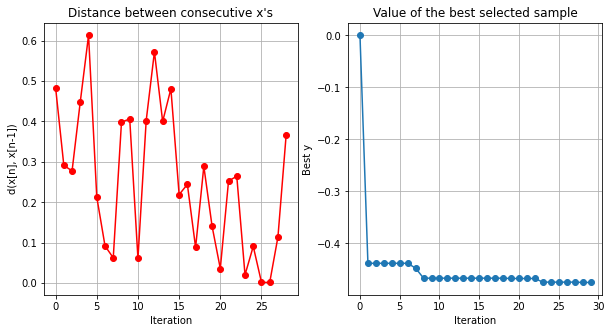

In [0]:
%matplotlib inline 
myProblem.plot_convergence() 

In [0]:
print(myProblem.x_opt, myProblem.fx_opt)

[1.99183825 0.26293892] -0.475267


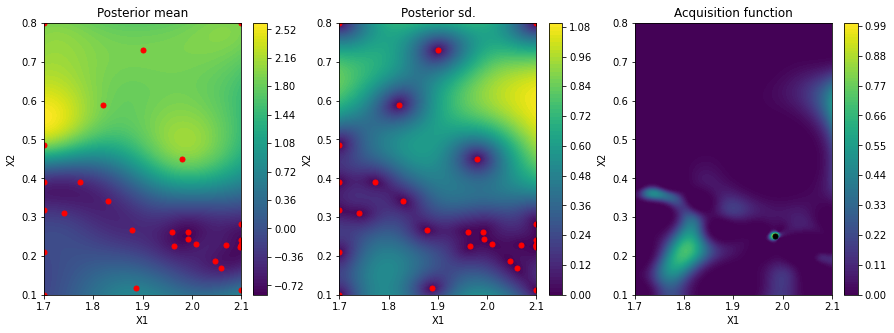

In [0]:
myProblem.plot_acquisition()

In [0]:
# Shutdown the Cluster
requests.post(
  "https://" + platform + "/api/v2/clusters/" + created_cluster["id"] + "/shutdown/",
  headers={"Authorization": token_in_header}
)

time.sleep(10)

# Get the Cluster's Status
raw_reply = requests.get(
  "https://" + platform + "/api/v2/clusters/" + created_cluster["id"] + "/statuses/",
  headers={"Authorization": token_in_header}
)
cluster_statuses = json.loads(raw_reply.text)
print("Cluster ID: " + created_cluster["id"] + ", Status date: " + cluster_statuses["results"][0]["statusDate"] + ", Status: " + cluster_statuses["results"][0]["status"])

Cluster ID: BBVthb, Status date: 2020-03-17T10:18:19.676000Z, Status: Stopping
